This notebook provides the code to calculate:
- A `csv` file with a cumulative number of unique prefixes for each AS. The file has three columns: AS, NumPrefix and CDF.
- Size of the bundles formed by considering unique prefixes - Includes a plot for the same.
- A `json` file which contains information about each bundle: AS number and the prefixes in the bundle
- A function to compare two bundle snapshots

Here, the following terms are described as:
- Unique prefixes: prefixes with unique AS paths from atleast 5 VPs
- Bundles: group of prefixes with identical AS paths


As a first step download the following dependencies:

In [ ]:
!sudo apt-get update
!sudo apt-get install -y curl apt-transport-https ssl-cert ca-certificates gnupg lsb-release
!curl -1sLf 'https://dl.cloudsmith.io/public/wand/libwandio/cfg/setup/bash.deb.sh' | sudo -E bash
!echo "deb https://pkg.caida.org/os/$(lsb_release -si|awk '{print tolower($0)}') $(lsb_release -sc) main" | sudo tee /etc/apt/sources.list.d/caida.list
!sudo wget -O /etc/apt/trusted.gpg.d/caida.gpg https://pkg.caida.org/os/ubuntu/keyring.gpg
!sudo apt update
!sudo apt-get install bgpstream -y
!pip install pybgpstream

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,007 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,

In [ ]:
from collections import defaultdict
import pybgpstream
import bisect
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import json

In this notebook, we will use BGPStream to get the ribdumps from 5 VPs. The `collectors` along with the `from_time ` and `until_time` are passed as parameters to the `collect_records` function to allow flexibility in future calculations. 

In [ ]:
def collect_records(collectors_list, start_time, end_time):

  """
  Input: Collectors (list)
         Start and end time in GMT (YYYY-MM-DD HH:MM:SS; String)

  Return: 2 Dictionaries: AS_prefix: Maps AS to prefix
                          prefix_path: Maps prefix to AS Path
  """

  stream = pybgpstream.BGPStream(
    # ALL TIMES ARE IN GMT
    from_time= start_time, until_time=end_time,
    collectors= collectors_list,
    record_type="ribs",
    filter="ipversion 4"
  )

  AS_prefix = defaultdict(set)           # dictionary that maps AS to prefixes it originates: {ASN1: {pfx1, pfx2}, ASN2: .....}
  prefix_path = defaultdict(list)        # dictionary that maps prefixes to AS path: {pfx1: {AS1, AS2, ..., origin}, pfx2: .....}

  for rec in stream.records():
      for elem in rec:
          # Get the prefix
          pfx = elem.fields["prefix"]
          # Get the list of ASes in the AS path
          ases = elem.fields["as-path"]
          if len(ases) > 0:
              # Get the origin ASn (rightmost)
              origin = ases.split()[-1]
              # Insert the origin ASn along with the prefix it originates
              AS_prefix[origin].add(pfx)

          bisect.insort(prefix_path[pfx],ases)        # to add paths in a sorted manner (makes comparison easier)

  return (AS_prefix, prefix_path)

Below are three functions for the calculations mentioned earlier:
- get_unique_pfx(AS_prefix, prefix_path) : Calculates the number of unique prefixes for each AS along with its CDF.
- get_bundle_count(AS_prefix, prefix_path) : Calculates the size of each bundle formed and plots a graph for the same.
- get_bundle_info(AS_prefix, prefix_path) : Calculates more information about the bundles including the ASN and prefixes it involves.

In [ ]:
def get_unique_pfx(AS_prefix, prefix_path):

  AS_unique_pfx = {}

  for asn, pfxs in AS_prefix.items():
    s = set()
    num_unique = 0
    for pfx in pfxs:
        n = " ".join(prefix_path[pfx])
        if n not in s:
            s.add(n)
            num_unique += 1

    AS_unique_pfx[asn] = num_unique

  return AS_unique_pfx

def get_bundle_count(AS_prefix, prefix_path):

  bundle_count = {}
  path2bundle = {}
  bundle2AS = {}
  
  c = 1
  for asn, pfxs in AS_prefix.items():
    s = set()
    for pfx in pfxs:
        n = " ".join(prefix_path[pfx])
        if n not in s:
            s.add(n)
            path2bundle[n] = c
            bundle2AS[c] = asn
            bundle_count[c] = 1
            c += 1
        else:
          bundle_count[path2bundle[n]] += 1

  return (bundle_count, bundle2AS)

def get_bundle_info(AS_prefix, prefix_path):

  path2bundle = {}
  bundle2AS = {}
  bundle_pfx = {}

  c = 1
  for asn, pfxs in AS_prefix.items():
      s = set()
      num_unique = 0
      for pfx in pfxs:
          n = " ".join(prefix_path[pfx])
          if n not in s:
              s.add(n)
              path2bundle[n] = c
              bundle2AS[c] = asn
              bundle_pfx[c] = [pfx]
              c += 1
          else:
            bisect.insort(bundle_pfx[path2bundle[n]],pfx)

  return (bundle2AS, bundle_pfx)


The following function `unique_to_csv` sorts all the ASNs and unique pfxs (makes the comparison and analysis easier) and stores them in a csv file.

In [ ]:
def unique_to_csv(AS_unique_pfx, name = "result_total.csv" ):

  AS = list(AS_unique_pfx.keys())
  unique_pfx = list(AS_unique_pfx.values())
  result_AS = [x for _, x in sorted(zip(unique_pfx, AS), reverse = True)]
  result_unique_pfx = sorted(unique_pfx, reverse = True)
  result_cdf = itertools.accumulate(result_unique_pfx)

  data = {
      "AS" : result_AS,
      "NumPrefix" : result_unique_pfx,
      "CDF" : result_cdf
  }

  df = pd.DataFrame(data)
  print(df.head())

  # Write the DataFrame to a CSV file
  df.to_csv(name)

In [ ]:
# Script that ties all the functions together to build a csv file
# with unique_pfx data

collectors=["route-views.chicago", "route-views.amsix", "route-views.bknix", "route-views.chile", "route-views.flix"]
from_time="2023-03-01 07:50:00"
until_time="2023-03-01 08:10:00"
AS_prefix, prefix_path = collect_records(collectors, from_time, until_time)

AS_unique_pfx = get_unique_pfx(AS_prefix, prefix_path)
unique_to_csv(AS_unique_pfx)


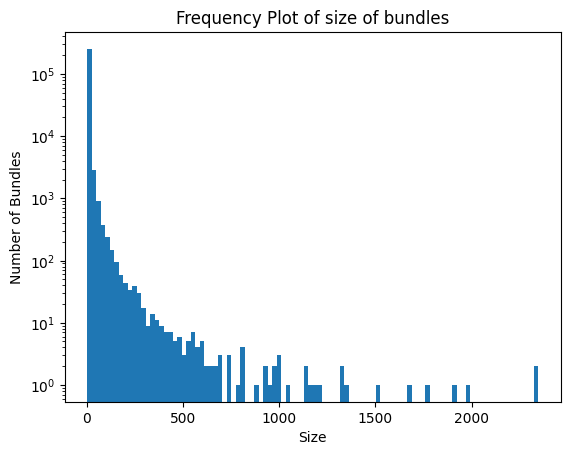

In [ ]:
# Plot of freq of size of bundle (number of bundles) vs size

bundle_count, bundle2AS = get_bundle_count(AS_prefix, prefix_path)
# Get the values from the dictionary
values = list(bundle_count.values())

# Create a histogram with 10 bins
plt.hist(values, bins=100, log=True)

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Number of Bundles')
plt.title("Frequency Plot of size of bundles")

# Display the plot
plt.show()

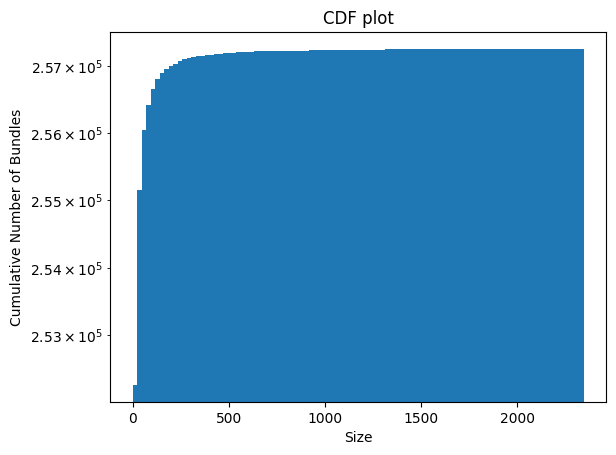

In [ ]:
import numpy as np

plt.hist(values, bins = 100, cumulative=True, log = True)

plt.xlabel('Size')
plt.ylabel('Cumulative Number of Bundles')
plt.title('CDF plot')

# Show the plot
plt.show()

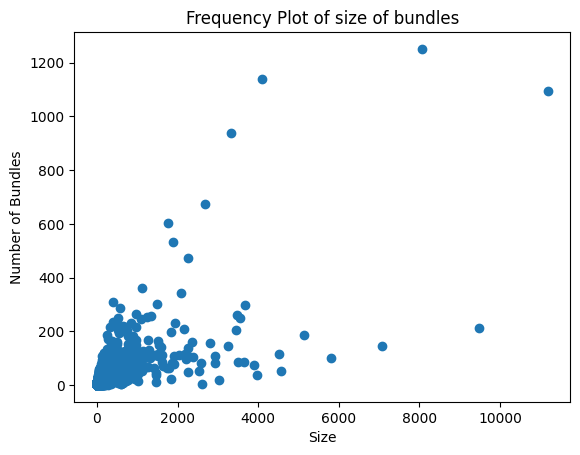

In [ ]:
# Plot of number of bundles vs number of prefixes for each AS

AS_counts = {}
pfx_count = []

for bundle, count in bundle_count.items():
    AS_number = bundle2AS.get(bundle)
    if AS_number is not None:
        AS_counts[AS_number] = AS_counts.get(AS_number, 0) + count

AS_counts_values = list(dict(sorted(AS_counts.items())).values())
pfx_count = list(dict(sorted(AS_unique_pfx.items())).values())

plt.scatter(AS_counts_values, pfx_count)

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Number of Bundles')
plt.title("Frequency Plot of size of bundles")

# Display the plot
plt.show()



The following function `bundles_to_json` sorts all the bundle values and prefixes (easy for comparison) and stores all the data in a json file

In [ ]:
def bundles_to_json(bundle2AS, bundle_pfx, name = 'bundle_data.json'):
  sorted_bundle2AS = {k: v for k, v in sorted(bundle2AS.items(), key=lambda item: item[1])}
  sorted_bundle_prefix = {k: sorted(v) for k, v in sorted(bundle_pfx.items(), key=lambda item: (sorted_bundle2AS[item[0]], item[1]))}

  # Create a list of dictionaries
  data = []
  for i, bundle in enumerate(sorted_bundle_prefix):
      AS = sorted_bundle2AS[bundle]
      prefixes = sorted_bundle_prefix[bundle]
      data.append({'serial number': i+1, 'bundle_number': bundle, 'AS': AS, 'prefixes': prefixes})

  # Write the list to a JSON file
  with open(name, 'w') as f:
      json.dump(data, f, indent=2)

In [ ]:
bundle2AS, bundle_pfx = get_bundle_info(AS_prefix, prefix_path)
bundles_to_json(bundle2AS, bundle_pfx)

In [ ]:
with open('bundle_data.json', 'r') as f:
    preview = f.read(1000)

# Print the preview to the console
print(preview)

[
  {
    "serial number": 1,
    "bundle_number": 103184,
    "AS": "1",
    "prefixes": [
      "140.106.223.0/24"
    ]
  },
  {
    "serial number": 2,
    "bundle_number": 103182,
    "AS": "1",
    "prefixes": [
      "155.133.112.0/21",
      "91.225.188.0/22"
    ]
  },
  {
    "serial number": 3,
    "bundle_number": 103181,
    "AS": "1",
    "prefixes": [
      "187.86.168.0/22",
      "187.86.168.0/24",
      "187.86.169.0/24",
      "187.86.170.0/24",
      "187.86.171.0/24"
    ]
  },
  {
    "serial number": 4,
    "bundle_number": 103180,
    "AS": "1",
    "prefixes": [
      "205.207.214.0/24"
    ]
  },
  {
    "serial number": 5,
    "bundle_number": 103185,
    "AS": "1",
    "prefixes": [
      "212.94.84.0/22"
    ]
  },
  {
    "serial number": 6,
    "bundle_number": 103183,
    "AS": "1",
    "prefixes": [
      "41.78.37.0/24"
    ]
  },
  {
    "serial number": 7,
    "bundle_number": 103186,
    "AS": "1",
    "prefixes": [
      "45.176.150.0/23"
    ]
  }

In [ ]:
bundles_to_json(bundle2AS, bundle_pfx, "bundle_data_2.json")

`compare_json_files` compares two json files. It returns true if both the files are identical. This will be useful when comparing two bundle snapshots

In [ ]:
def compare_json_files(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        while True:
            byte1 = f1.read(1)
            byte2 = f2.read(1)
            if byte1 != byte2:
                return False
            if not byte1:
                return True

In [ ]:
compare_json_files('bundle_data.json', 'bundle_data_2.json')

True